# Debugging Faster R-CNN Networks

## Imports

In [1]:
import sys
sys.path.append('../')

import numpy as np
np.set_printoptions(precision=3)
import tensorflow as tf

## Check Cythonized modules working

#### bbox_overlaps

In [2]:
from Lib.bbox_overlaps import bbox_overlaps

In [3]:
boxes = np.array([[1,3,2,4],
                  [2,5,1,8],
                  [3,4,9,9],
                  [1,9,7,11]],dtype=np.float)

In [4]:
query_boxes = np.array([[1,3,2,4],
                  [5,3,7,4],
                  [1,8,10,12],
                  [0,2,3,5],
                  [0,3,2,9],
                  [2,1,3,4]],dtype=np.float)

In [5]:
bbox_overlaps(boxes,query_boxes)

array([[ 1.   ,  0.   ,  0.   ,  0.25 ,  0.19 ,  0.2  ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.067,  0.179,  0.036,  0.   ,  0.02 ],
       [ 0.   ,  0.   ,  0.42 ,  0.   ,  0.05 ,  0.   ]])

#### nms

In [6]:
from Lib.nms_wrapper import nms

In [7]:
proposals = 10*np.array([[2,1,12,21,0],
                     [10,5,14,18,.1],
                     [5,3,11,14,.2],
                     [1,4,20,20,.3]],dtype=np.float32)
copies = np.random.choice(4,256,p=[0.1,0.2,0.3,0.4])
proposals = proposals[copies,:]
perturbations = np.random.randint(8,size=(256,4))
perturbations = np.concatenate((perturbations,np.zeros([256,1])),1)
proposals = np.array(proposals + perturbations,dtype=np.float32)

In [8]:
keep = nms(proposals,0.7)
proposals[keep,:]

array([[  11.,   46.,  205.,  207.,    3.],
       [  50.,   32.,  111.,  142.,    2.],
       [ 106.,   52.,  146.,  187.,    1.],
       [  23.,   13.,  124.,  215.,    0.]], dtype=float32)

## Test fast_rcnn

In [9]:
from Networks.convnet import convnet
from Networks.faster_rcnn_networks import rpn, roi_proposal, fast_rcnn

In [10]:
# Global Dictionary of Flags
flags = {
    'data_directory': '../Data/MNIST/',
    'save_directory': '../Logs/summaries/',
    'model_directory': 'resnet101/',
    'restore': False,
    'restore_file': 'start.ckpt',
    'datasets': 'MNIST',
    'image_dim': 28,
    'hidden_size': 10,
    'num_classes': 10,
    'batch_size': 1,
    'display_step': 200,
    'weight_decay': 1e-7,
    'lr_decay': 0.999,
    'num_epochs': 10,
    'lr_iters': [(5e-3, 5000), (5e-3, 7500), (5e-4, 10000), (5e-5, 10000)],
    'anchor_scales': [1,2,4]
}
eval_mode = False

#### Set up inputs

In [11]:
x = tf.placeholder(tf.float32, [1, 128, 128, 3], name='x')
gt_boxes = tf.placeholder(tf.int64, [1, 5], name='gt')
im_dims = tf.placeholder(tf.int64, [1, 2], name='im_dims')

#### Convolutional Feature Extractor

In [12]:
cnn = convnet(x, [5, 3, 3, 3, 3], [64, 96, 128, 172, 256], strides=[2, 2, 2, 2, 2])
featureMaps = cnn.get_output()
_feat_stride = cnn.get_feat_stride()

conv_1 output: (1, 64, 64, 64)
conv_2 output: (1, 32, 32, 96)
conv_3 output: (1, 16, 16, 128)
conv_4 output: (1, 8, 8, 172)
conv_5 output: (1, 4, 4, 256)


#### RPN

In [13]:
rpn_net = rpn(featureMaps,gt_boxes,im_dims,_feat_stride,eval_mode,flags)

conv_1 output: (1, 4, 4, 128)
conv_1 output: (1, 4, 4, 18)
conv_1 output: (1, 4, 4, 36)


In [14]:
rpn_cls_score = rpn_net.get_rpn_cls_score()
rpn_cls_score.get_shape()

TensorShape([Dimension(1), Dimension(4), Dimension(4), Dimension(18)])

In [15]:
rpn_labels = rpn_net.get_rpn_labels()
rpn_labels.get_shape()

TensorShape(None)

In [16]:
rpn_bbox_pred = rpn_net.get_rpn_bbox_pred()
rpn_bbox_pred.get_shape()

TensorShape([Dimension(1), Dimension(4), Dimension(4), Dimension(36)])

In [17]:
rpn_bbox_targets = rpn_net.get_rpn_bbox_targets()
rpn_bbox_targets.get_shape()

TensorShape(None)

In [18]:
rpn_bbox_outside_weights = rpn_net.get_rpn_bbox_outside_weights()
rpn_bbox_outside_weights.get_shape()

TensorShape(None)

#### ROI Proposal

In [19]:
rpn_cls_score = rpn_net.get_rpn_cls_score()
rpn_bbox_pred = rpn_net.get_rpn_bbox_pred()
roi_proposal_net = roi_proposal(rpn_net, gt_boxes, im_dims, eval_mode, flags)

In [20]:
roi_proposal_net.get_rois().get_shape()

TensorShape([Dimension(None), Dimension(5)])

In [21]:
roi_proposal_net.get_labels().get_shape()

TensorShape(None)

In [22]:
roi_proposal_net.get_bbox_targets().get_shape()

TensorShape(None)

#### Fast RCNN

In [23]:
fast_rcnn_net = fast_rcnn(featureMaps, roi_proposal_net, eval_mode)

flat_1 output: (?, 12544)
fc_1 output: (?, 1024)
fc_1 output: (?, 10)
fc_1 output: (?, 40)


In [24]:
fast_rcnn_net.get_cls_score().get_shape()

TensorShape([Dimension(None), Dimension(10)])

In [25]:
fast_rcnn_net.get_bbox_refinement().get_shape()

TensorShape([Dimension(None), Dimension(40)])

#### Feed dummy values through net

In [26]:
# Prevent TensorFlow from completely hogging up all GPUs
config = tf.ConfigProto(log_device_placement=False)
config.gpu_options.per_process_gpu_memory_fraction=0.2
sess = tf.InteractiveSession(config=config)

In [27]:
x_in = np.random.randint(256,size=[1, 128, 128, 3])
gt_in = np.array([1,4,16,20,3]).reshape([1,5])
im_dims_in = np.array([128]*1*2).reshape([1,2])

In [28]:
sess.run(tf.global_variables_initializer())
#sess.run(rpn_bbox_targets,feed_dict={x: x_in, gt: gt_in, im_dims: im_dims_in})

## Test ROI pooling layer

In [29]:
import tensorflow as tf
from scipy.misc import imread
import matplotlib.pyplot as plt
from Lib.roi_pool import roi_pool

In [30]:
# Set up tensorflow graph
featMap_tf = tf.placeholder(tf.float32, [None, 128, 128, 1])
roi_tf = tf.placeholder(tf.float32, [None, 5])
im_dims_tf = tf.placeholder(tf.int32, [None, 2])      

pooledFeatures = roi_pool(featMap_tf,roi_tf,im_dims_tf)

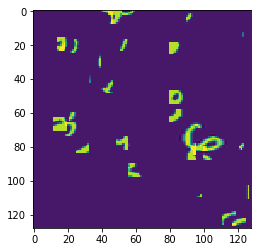

[[128 128]]


In [31]:
imfile = '../Data/data_clutter/Test/Images/img88.png'
img = imread(imfile)
im_dims = np.array(img.shape)
im_dims = im_dims.reshape((-1,2))
plt.imshow(img)
plt.show()
print(im_dims)

In [32]:
gt = np.loadtxt('../Data/data_clutter/Test/Annotations/img88.txt', ndmin=2)
gt_box = gt[:,:4]

roi = np.concatenate(([[0]],gt_box),axis=1)
roi

array([[   0.,   76.,   65.,  118.,   88.]])

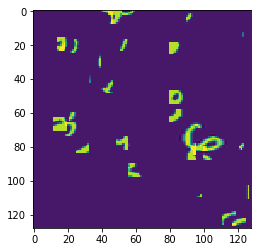

(1, 128, 128, 1)


In [33]:
# This would be a really dumb output for a CNN, 
# but for testing purposes, it'll do
featureMaps = img[::1,::1]
plt.imshow(featureMaps)
plt.show()
featureMaps = featureMaps.reshape((1,featureMaps.shape[0],featureMaps.shape[1],1))
print(featureMaps.shape)

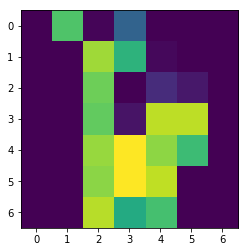

(7, 7)
[[  16.    189.59   19.59   91.95   16.71   16.     16.  ]
 [  16.     16.02  221.2   170.63   20.69   16.     16.  ]
 [  16.     16.75  201.85   16.     45.92   31.11   16.  ]
 [  16.     16.7   197.77   28.6   230.77  231.21   16.12]
 [  16.     16.05  217.91  255.    214.1   179.82   16.09]
 [  16.     16.    213.83  255.    232.17   16.32   16.  ]
 [  16.     16.    229.    162.    184.95   16.     16.  ]]


In [34]:
# Run the graph and pray
out = sess.run(pooledFeatures, feed_dict={featMap_tf: featureMaps, roi_tf: roi, im_dims_tf: im_dims})
im_out = np.squeeze(out)
plt.imshow(im_out)
plt.show()
print(im_out.shape)
np.set_printoptions(precision=2)
print(im_out)

## Test losses/reshaping

In [62]:
# Dummy RPN Classification Scores
N = 1   # Minibatch size
W = 16  # Width of feature maps
H = 16  # Height of feature maps
K = 9*2 # Number of scores

rpn_cls_score = np.array([[[[k + 100*h + 10000*w + 1000000*n for k in range(K)] for h in range(H)] for w in range(W)] for n in range(N)])
print(rpn_cls_score[0,4,10,0])
print(rpn_cls_score[0,4,10,1])
print(rpn_cls_score[0,11,3,11])
print(rpn_cls_score[0,11,3,10])
print(rpn_cls_score[0,1,8,16])
print(rpn_cls_score[0,1,8,17])

41000
41001
110311
110310
10816
10817


In [63]:
# Reshape for softmax
shape = rpn_cls_score.shape
print("Shape: {0}".format(shape))

rpn_cls_score = np.transpose(rpn_cls_score,[0,3,1,2])
rpn_cls_score = np.reshape(rpn_cls_score,[shape[0],2,shape[3]//2*shape[1],shape[2]])
rpn_cls_score = np.transpose(rpn_cls_score,[0,2,3,1])

print("Reshaped: {0}".format(rpn_cls_score.shape))
print(rpn_cls_score[0,100,10,0])
print(rpn_cls_score[0,100,10,1])
print(rpn_cls_score[0,41,7,0])
print(rpn_cls_score[0,41,7,1])
print(rpn_cls_score[0,141,3,0])
print(rpn_cls_score[0,141,3,1])

Shape: (1, 16, 16, 18)
Reshaped: (1, 144, 16, 2)
41006
41015
90702
90711
130308
130317


In [66]:
# Reshape for loss
rpn_cls_score = np.reshape(rpn_cls_score,[-1,2])
print("Shape: {0}".format(rpn_cls_score.shape))

print(rpn_cls_score[5,:])
print(rpn_cls_score[259,:])
print(rpn_cls_score[1978,:])

Shape: (2304, 2)
[500 509]
[301 310]
[111007 111016]
